In [ ]:
import splitfolders

# Split with ratio (80% train, 20% val)
splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/processed_frames', output='processed4',
                  seed=42, ratio=(.8, .2), group_prefix=None)

In [ ]:
# ✅ Cell 2: Config


# Constants
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 13
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/processed_frames'

# Load datasets
train_dataset = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_dataset.class_names



Found 55023 files belonging to 6 classes.
Using 44019 files for training.
Found 55023 files belonging to 6 classes.
Using 11004 files for validation.


In [ ]:
# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Model definition
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # freeze the base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]


In [ ]:
# Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/13
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9581 - loss: 0.1707

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 113s 69ms/step - accuracy: 0.9581 - loss: 0.1706 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/13
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 3.8078e-04 - learning_rate: 0.0010
Epoch 3/13
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - accuracy: 1.0000 - loss: 7.3044e-04 - val_accuracy: 1.0000 - val_loss: 1.7668e-04 - learning_rate: 0.0010
Epoch 4/13
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - accuracy: 1.0000 - loss: 3.4522e-04 - val_accuracy: 1.0000 - val_loss: 1.2066e-04 - learning_rate: 0.0010
Epoch 5/13
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 2.2097e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - accuracy: 1.0000 - loss: 2.2100e-04 - val_accuracy: 0.9999 - val_loss: 1.5898e-04 - learning_rate: 0.0010
Epoch 6/13
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7

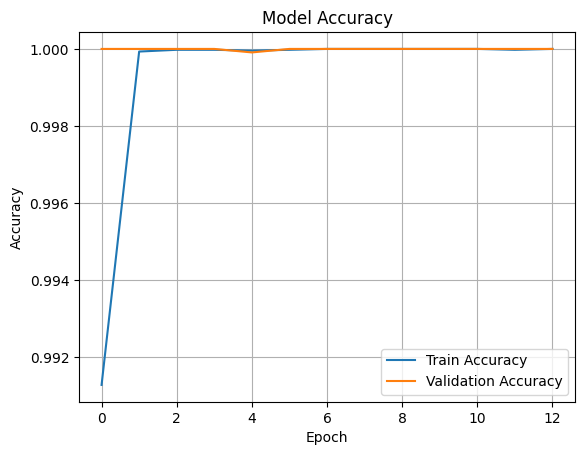

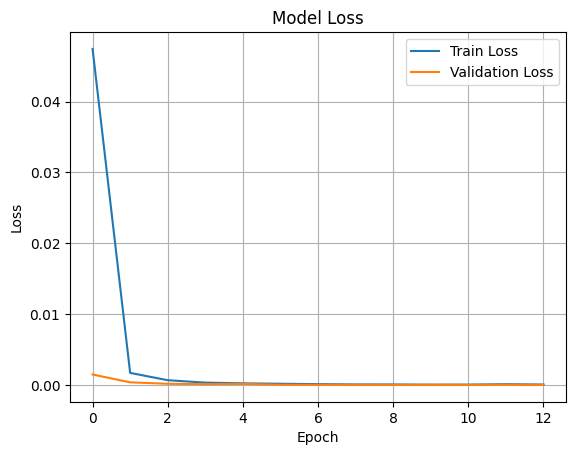

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
class_names = list(train_dataset.class_names)
print("Class names:", class_names)


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

344/344 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step


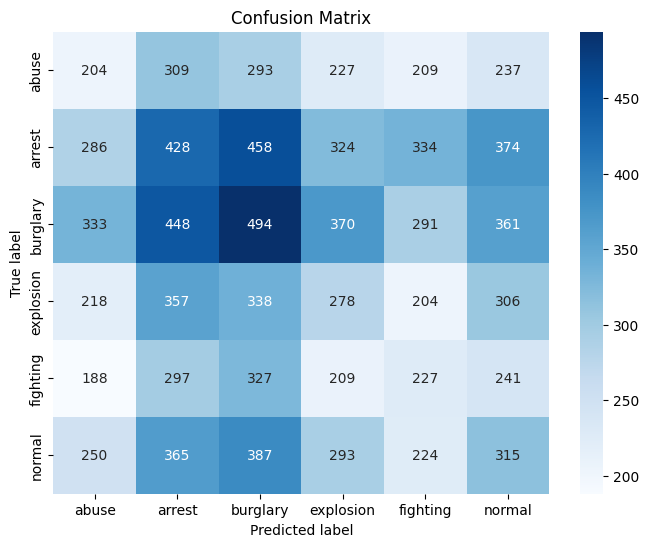

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predictions
y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("y_pred shape:", y_pred.shape)
print("Example prediction vector:", y_pred[0])
print("Predicted classes:", y_pred_classes[:10])
print("True classes:", y_true_classes[:10])


y_pred shape: (11004, 6)
Example prediction vector: [4.7192130e-09 1.0616170e-07 9.9999940e-01 2.6985057e-07 1.5285089e-08
 2.3426610e-07]
Predicted classes: [2 2 5 5 1 4 3 0 0 5]
True classes: [1 3 3 3 1 0 5 1 4 2]


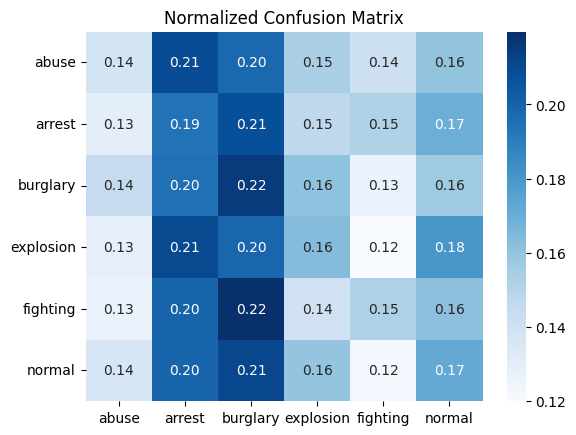

In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


              precision    recall  f1-score   support

       abuse       0.14      0.14      0.14      1479
      arrest       0.19      0.19      0.19      2204
    burglary       0.22      0.22      0.22      2297
   explosion       0.16      0.16      0.16      1701
    fighting       0.15      0.15      0.15      1489
      normal       0.17      0.17      0.17      1834

    accuracy                           0.18     11004
   macro avg       0.17      0.17      0.17     11004
weighted avg       0.18      0.18      0.18     11004



I want to try the EfficientNetB4

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/content/drive/MyDrive/Colab Notebooks/processed_frames"

IMG_SIZE = 224
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 split
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 44020 images belonging to 6 classes.
Found 11003 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)  # 6 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 18,594,917 (70.93 MB)

 Trainable params: 921,094 (3.51 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
# Train the top layers first
history2=model.fit(train_generator, epochs=10, validation_data=val_generator)



Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.3168 - loss: 1.6219

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 716s 497ms/step - accuracy: 0.3168 - loss: 1.6218 - val_accuracy: 0.2206 - val_loss: 1.7213
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 651s 473ms/step - accuracy: 0.4262 - loss: 1.4274 - val_accuracy: 0.3268 - val_loss: 1.6703
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 652s 474ms/step - accuracy: 0.4903 - loss: 1.3185 - val_accuracy: 0.3200 - val_loss: 1.6835
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 654s 475ms/step - accuracy: 0.5248 - loss: 1.2463 - val_accuracy: 0.3574 - val_loss: 1.6848
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 645s 469ms/step - accuracy: 0.5529 - loss: 1.1864 - val_accuracy: 0.3743 - val_loss: 1.6306
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 646s 470ms/step - accuracy: 0.5627 - loss: 1.1497 - val_accuracy: 0.3729 - val_loss: 1.6526
Epoch 7/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 640s 465ms/step - accuracy: 0.5779 - loss: 1.1156 - val_accuracy: 0.4043 - val_loss: 1.5959
Epoch 8/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 645s 468ms/step - accuracy: 0.5

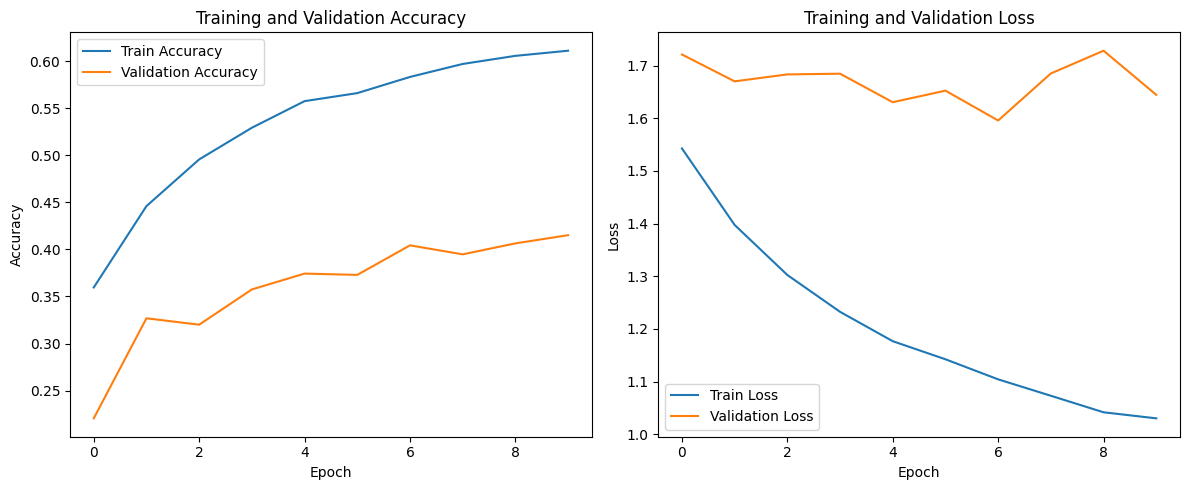

In [ ]:
import matplotlib.pyplot as plt

def plot_saved_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot using your saved history2
plot_saved_history(history2)

Found 11003 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 47s 137ms/step


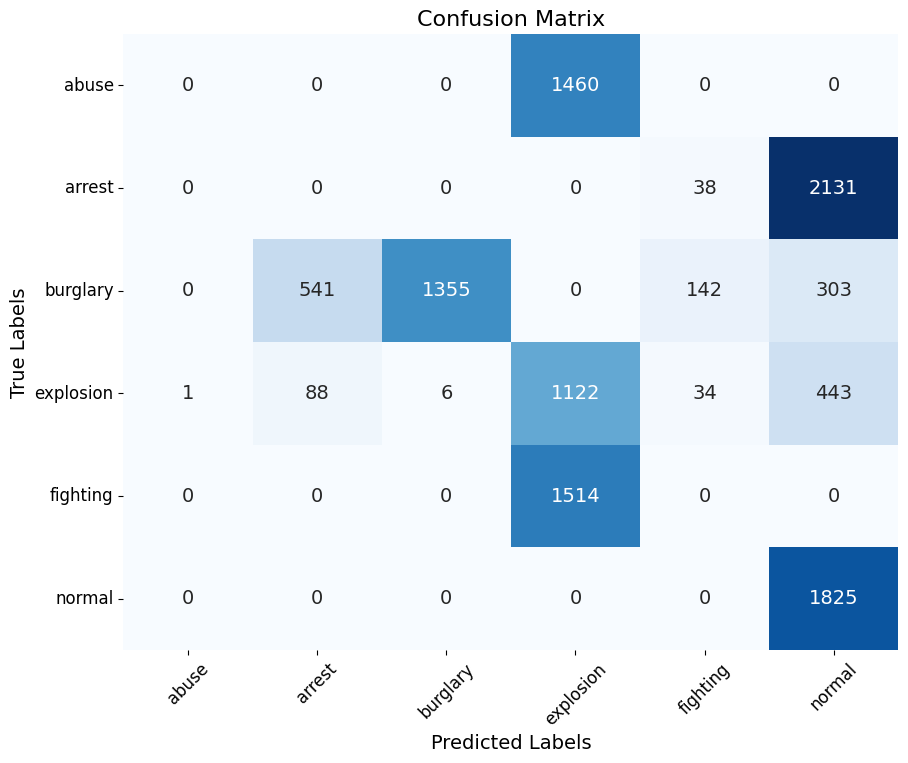

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Recreate validation generator (important: shuffle=False)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # CRUCIAL for correct labels
)

# Get true labels and predictions
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get class names
class_names = list(val_generator.class_indices.keys())

# Create confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar=False, annot_kws={'size': 14})

    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

    # Add percentages

    plt.show()

plot_confusion_matrix(y_true, y_pred, class_names)

In [ ]:
# Unfreeze deeper layers and fine-tune
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history3=model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 624s 423ms/step - accuracy: 0.5974 - loss: 1.2978 - val_accuracy: 0.5478 - val_loss: 1.9175
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 548s 398ms/step - accuracy: 0.6894 - loss: 0.8402 - val_accuracy: 0.5817 - val_loss: 2.0523
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 550s 400ms/step - accuracy: 0.7377 - loss: 0.7218 - val_accuracy: 0.7032 - val_loss: 1.8154
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 552s 401ms/step - accuracy: 0.7642 - loss: 0.6489 - val_accuracy: 0.5687 - val_loss: 1.7051
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 561s 408ms/step - accuracy: 0.7874 - loss: 0.5856 - val_accuracy: 0.6027 - val_loss: 2.0968
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 554s 403ms/step - accuracy: 0.8038 - loss: 0.5454 - val_accuracy: 0.6055 - val_loss: 2.0730
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 553s 402ms/step - accuracy: 0.8139 - loss: 0.5109 - val_accuracy: 0.6240 - val_loss: 1.8358
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 557s 404ms/step - ac

In [ ]:
model.save('/content/drive/MyDrive/efficientnet_model.h5')


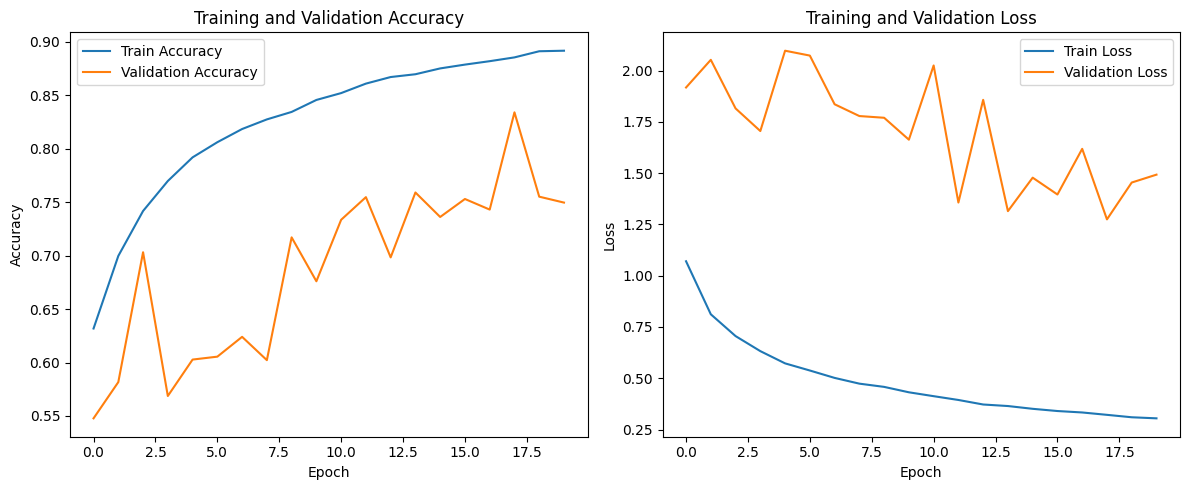

In [ ]:
import matplotlib.pyplot as plt

def plot_saved_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot using your saved history2
plot_saved_history(history3)

Found 11003 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 62s 153ms/step


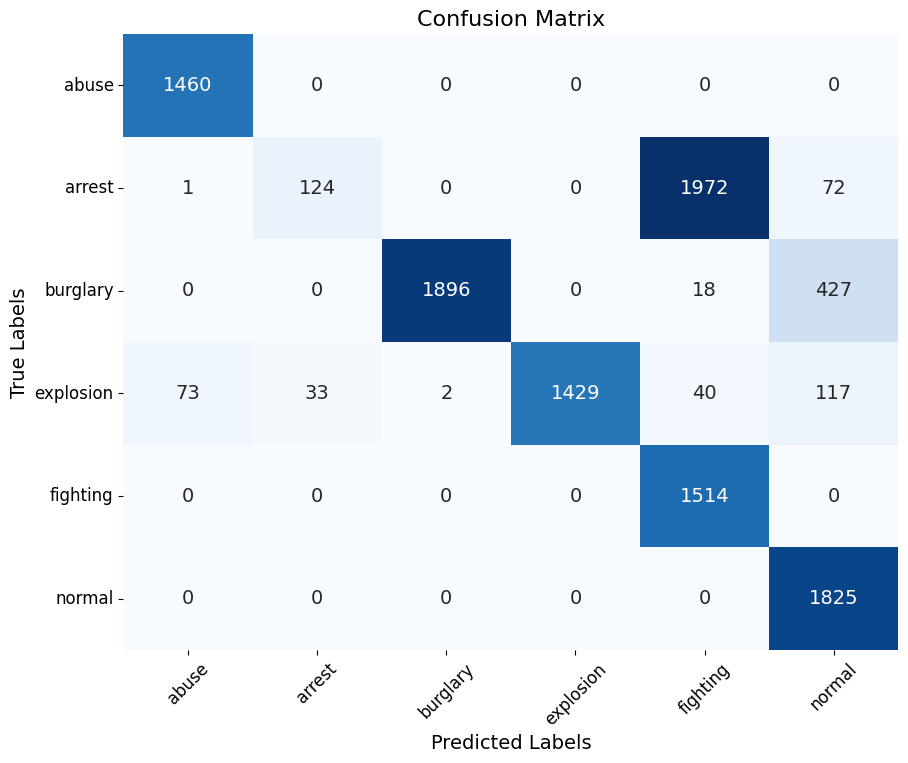

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Recreate validation generator (important: shuffle=False)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # CRUCIAL for correct labels
)

# Get true labels and predictions
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get class names
class_names = list(val_generator.class_indices.keys())

# Create confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar=False, annot_kws={'size': 14})

    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

    # Add percentages

    plt.show()

plot_confusion_matrix(y_true, y_pred, class_names)

The same model with autotune


In [ ]:
import os
import random
from shutil import copyfile

# 1. First, organize videos (not frames) into groups
video_groups = {}
for class_name in ['abuse', 'arrest', 'burglary', 'fighting', 'explosion', 'normal']:
    video_folders = [f for f in os.listdir(f'/content/drive/MyDrive/Colab Notebooks/processed_frames/{class_name}')
                    if os.path.isdir(f'/content/drive/MyDrive/Colab Notebooks/processed_frames/{class_name}/{f}')]
    video_groups[class_name] = video_folders
print(video_groups)
# 2. Split videos (not frames) 80/20
for class_name, videos in video_groups.items():
    random.seed(42)
    random.shuffle(videos)
    split_idx = int(0.8 * len(videos))

    # Create directories
    os.makedirs(f'/content/drive/MyDrive/Colab Notebooks/train/{class_name}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/Colab Notebooks/val/{class_name}', exist_ok=True)

    # Copy entire video folders
    for video in videos[:split_idx]:
        src = f'/content/drive/MyDrive/Colab Notebooks/processed_frames/{class_name}/{video}'
        dst = f'/content/drive/MyDrive/Colab Notebooks/train/{class_name}/{video}'
        os.system(f'cp -r "{src}" "{dst}"')

    for video in videos[split_idx:]:
        src = f'/content/drive/MyDrive/Colab Notebooks/processed_frames/{class_name}/{video}'
        dst = f'/content/drive/MyDrive/Colab Notebooks/val/{class_name}/{video}'
        os.system(f'cp -r "{src}" "{dst}"')

{'abuse': ['Abuse001_x264.mp4', 'Abuse003_x264.mp4', 'Abuse002_x264.mp4'], 'arrest': ['Arrest001_x264.mp4', 'Arrest004_x264.mp4', 'Arrest003_x264.mp4', 'Arrest002_x264.mp4'], 'burglary': ['burglary003', 'burglary004'], 'fighting': ['fighting003', 'fighting002', 'fighting001'], 'explosion': ['Explosion001_x264.mp4', 'Explosion002_x264.mp4', 'Explosion004_x264.mp4', 'Explosion006_x264.mp4'], 'normal': ['normal008', 'normal005', 'normal004', 'normal003', 'normal006', 'normal007', 'normal002', 'normal001']}


In [ ]:
# --------------------------
# Cell 1: Imports & Setup
# --------------------------
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.initializers import GlorotUniform
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict
import matplotlib.pyplot as plt

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Define paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/val'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
TRAIN_FRAMES_PER_VIDEO = 15
VAL_FRAMES_PER_VIDEO = 20

# Get class info
class_names = sorted(os.listdir(train_dir))
class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
num_classes = len(class_names)

# Calculate class weights
video_counts = defaultdict(int)
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        video_counts[class_name] = len(os.listdir(class_path))
class_weights = {
    class_indices[cls]: sum(video_counts.values())/(len(video_counts)*count)
    for cls, count in video_counts.items()
}
print("Class weights:", class_weights)

Class weights: {2: 2.8333333333333335, 4: 1.4166666666666667, 3: 0.9444444444444444, 5: 0.4722222222222222, 0: 1.4166666666666667, 1: 0.9444444444444444}


In [ ]:
# # --------------------------
# # Cell 2: Enhanced Data Generator
# # --------------------------
# class VideoAwareGenerator(ImageDataGenerator):
#     def __init__(self, frames_per_video=15, class_weights=None, **kwargs):
#         super().__init__(**kwargs)
#         self.frames_per_video = frames_per_video
#         self.class_weights = class_weights if class_weights else {}

#     def flow_from_videos(self, directory):
#         while True:
#             video_paths = []
#             for class_name in os.listdir(directory):
#                 class_path = os.path.join(directory, class_name)
#                 if os.path.isdir(class_path):
#                     for video_folder in os.listdir(class_path):
#                         video_path = os.path.join(class_path, video_folder)
#                         if os.path.isdir(video_path):
#                             video_paths.append((video_path, class_name))

#             np.random.shuffle(video_paths)

#             for video_path, class_name in video_paths:
#                 frames = [f for f in os.listdir(video_path)
#                          if f.lower().endswith(('.jpg','.jpeg','.png'))]

#                 if not frames:
#                     continue

#                 if len(frames) > self.frames_per_video:
#                     frames = np.random.choice(frames, self.frames_per_video, replace=False)

#                 batch_x = []
#                 batch_y = []
#                 sample_weights = []
#                 class_idx = class_indices[class_name]
#                 weight = self.class_weights.get(class_idx, 1.0)

#                 for frame in frames:
#                     img = load_img(os.path.join(video_path, frame), target_size=IMG_SIZE)
#                     img = img_to_array(img)
#                     batch_x.append(img)
#                     batch_y.append(class_idx)
#                     sample_weights.append(weight)

#                 yield np.array(batch_x)/255.0, np.array(batch_y), np.array(sample_weights)

# # Create generators
# train_datagen = VideoAwareGenerator(
#     frames_per_video=TRAIN_FRAMES_PER_VIDEO,
#     class_weights=class_weights,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     vertical_flip=True,
#     brightness_range=[0.7, 1.3],
#     fill_mode='nearest'
# )

# val_datagen = VideoAwareGenerator(
#     frames_per_video=VAL_FRAMES_PER_VIDEO
# )

# train_gen = train_datagen.flow_from_videos(train_dir)
# val_gen = val_datagen.flow_from_videos(val_dir)
# --------------------------
# Cell 2: Simplified Data Pipeline
# --------------------------
# Replace existing generator code with:

# Basic augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2  # Reduced from 0.3
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=64,  # Increased from 32
    class_mode='sparse'  # Changed from categorical
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='sparse',
    shuffle=False
)

# More aggressive class weights
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(train_gen.classes),
                                   y=train_gen.classes)
class_weights = {i:w*3 for i,w in enumerate(class_weights)}  # Tripled weights
print("Boosted class weights:", class_weights)

Found 79671 images belonging to 6 classes.
Found 12227 images belonging to 6 classes.
Boosted class weights: {0: np.float64(6.187558247903075), 1: np.float64(4.702573486011096), 2: np.float64(1.7682661576704546), 3: np.float64(2.5421506062539887), 4: np.float64(3.441809227579057), 5: np.float64(2.6574716477651767)}


In [ ]:
# --------------------------
# Cell 3: Replace with Smaller Model
# --------------------------
from tensorflow.keras.applications import MobileNetV2

# Remove old EfficientNet code and replace with:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Simplified head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)  # Reduced from 512 to 128
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers initially
base_model.trainable = False

# Simplified optimizer
model.compile(
    optimizer=Adam(3e-4),  # Higher initial learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# --------------------------
# Cell 4: Faster Training Protocol
# --------------------------
# Replace existing training code with:

# Phase 1: Train head only
print("\n=== Phase 1: Training Head ===")
history5 = model.fit(
    train_gen,
    steps_per_epoch=50,  # Reduced steps for speed
    epochs=10,  # Reduced epochs
    validation_data=val_gen,
    validation_steps=10,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=3),
        ModelCheckpoint('quick_model.h5')
    ]
)

# Phase 2: Partial unfreeze
print("\n=== Phase 2: Partial Unfreeze ===")
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

model.compile(
    optimizer=Adam(1e-5),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history6 = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=5,  # Short second phase
    validation_data=val_gen,
    validation_steps=10,
    class_weight=class_weights
)


=== Phase 1: Training Head ===
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - accuracy: 0.9997 - loss: 0.0244 

50/50 ━━━━━━━━━━━━━━━━━━━━ 2653s 53s/step - accuracy: 0.9997 - loss: 0.0243 - val_accuracy: 0.0000e+00 - val_loss: 8.4893
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 51s/step - accuracy: 1.0000 - loss: 0.0146 

50/50 ━━━━━━━━━━━━━━━━━━━━ 2549s 51s/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.0000e+00 - val_loss: 8.5417
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 48s/step - accuracy: 1.0000 - loss: 0.0095 

50/50 ━━━━━━━━━━━━━━━━━━━━ 2382s 48s/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 0.0000e+00 - val_loss: 8.6683
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 47s/step - accuracy: 0.9983 - loss: 0.0105 

50/50 ━━━━━━━━━━━━━━━━━━━━ 2351s 47s/step - accuracy: 0.9983 - loss: 0.0105 - val_accuracy: 0.0000e+00 - val_loss: 8.7616

=== Phase 2: Partial Unfreeze ===
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2223s 44s/step - accuracy: 0.9329 - loss: 0.3722 - val_accuracy: 0.0000e+00 - val_loss: 8.5709
Epoch 2/5
48/50 ━━━━━━━━━━━━━━━━━━━━ 1:26 43s/step - accuracy: 0.9975 - loss: 0.0504

KeyboardInterrupt: 

In [ ]:
# --------------------------
# New Cell: Presentation-Ready Evaluation
# --------------------------
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions
val_gen.reset()  # Important for correct ordering
y_true = val_gen.classes
y_pred = model.predict(val_gen).argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix - MobileNetV2')
plt.show()

# Class-wise accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nClass-wise Validation Accuracy:")
for cls, acc in zip(class_names, class_acc):
    print(f"{cls:15}: {acc:.1%}")

# Video prediction demo function
def predict_video(video_folder, model, threshold=0.6):
    """Demo function for presentation"""
    frames = []
    for frame_file in os.listdir(video_folder)[:15]:  # First 15 frames
        img = load_img(os.path.join(video_folder, frame_file),
                      target_size=IMG_SIZE)
        img = img_to_array(img)/255.0
        frames.append(img)

    preds = model.predict(np.array(frames))
    avg_pred = np.mean(preds, axis=0)

    if np.max(avg_pred) > threshold:
        return class_names[np.argmax(avg_pred)]
    else:
        return "Normal (uncertain)"

# Example usage (replace with your video path):
test_video_path = os.path.join(val_dir, list(class_names)[0], os.listdir(os.path.join(val_dir, list(class_names)[0]))[0])
print(f"\nSample Prediction: {predict_video(test_video_path, model)}")

In [ ]:
# Cell 7: Save Model
model.save('/content/drive/MyDrive/surveillance_model.keras')
print("Model saved to Google Drive")

In [ ]:
import shutil

# WARNING: This will delete all contents in train/ and val/
shutil.rmtree('/content/drive/MyDrive/Colab Notebooks/train')
shutil.rmtree('/content/drive/MyDrive/Colab Notebooks/val')


In [ ]:
train_directory=os.makedirs('/content/drive/MyDrive/Colab Notebooks/train', exist_ok=True)
val_directory=os.makedirs('/content/drive/MyDrive/Colab Notebooks/val', exist_ok=True)


In [ ]:
import os
import random
from shutil import copyfile

# 1. First, organize videos (not frames) into groups
video_groups = {}
for class_name in ['abuse', 'arrest', 'burglary', 'fighting', 'explosion', 'normal']:
    video_folders = [f for f in os.listdir(f'/content/drive/MyDrive/Colab Notebooks/processed_frames/{class_name}')
                    if os.path.isdir(f'/content/drive/MyDrive/Colab Notebooks/processed_frames/{class_name}/{f}')]
    video_groups[class_name] = video_folders
print(video_groups)
# 2. Split videos (not frames) 80/20
for class_name, videos in video_groups.items():
    random.seed(42)
    random.shuffle(videos)
    split_idx = int(0.8 * len(videos))

    # Create directories
    os.makedirs(f'/content/drive/MyDrive/Colab Notebooks/train/{class_name}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/Colab Notebooks/val/{class_name}', exist_ok=True)

    # Copy entire video folders
    for video in videos[:split_idx]:
        src = f'/content/drive/MyDrive/Colab Notebooks/processed_frames/{class_name}/{video}'
        dst = f'/content/drive/MyDrive/Colab Notebooks/train/{class_name}/{video}'
        os.system(f'cp -r "{src}" "{dst}"')

    for video in videos[split_idx:]:
        src = f'/content/drive/MyDrive/Colab Notebooks/processed_frames/{class_name}/{video}'
        dst = f'/content/drive/MyDrive/Colab Notebooks/val/{class_name}/{video}'
        os.system(f'cp -r "{src}" "{dst}"')

{'abuse': ['Abuse001_x264.mp4', 'Abuse003_x264.mp4', 'Abuse002_x264.mp4'], 'arrest': ['Arrest001_x264.mp4', 'Arrest004_x264.mp4', 'Arrest003_x264.mp4', 'Arrest002_x264.mp4'], 'burglary': ['burglary003', 'burglary004'], 'fighting': ['fighting003', 'fighting002', 'fighting001'], 'explosion': ['Explosion001_x264.mp4', 'Explosion002_x264.mp4', 'Explosion004_x264.mp4', 'Explosion006_x264.mp4'], 'normal': ['normal008', 'normal005', 'normal004', 'normal003', 'normal006', 'normal007', 'normal002', 'normal001']}


In [ ]:
# Human Behavior Detection System - Complete Implementation Plan
# This file provides the steps in order of execution

'''
STEP 1: DATA PREPARATION AND ANALYSIS
'''

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
data_dir = '/content/drive/MyDrive/Colab Notebooks/processed_frames'

def analyze_dataset(data_dir):
    """
    Analyze the existing dataset structure and class distribution

    Args:
        data_dir: Root directory containing class subdirectories
    """
    class_stats = {}
    total_frames = 0

    # Get all class directories
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    print(f"Found {len(class_dirs)} classes: {', '.join(class_dirs)}")

    # Analyze each class directory
    for class_name in class_dirs:
        class_path = os.path.join(data_dir, class_name)
        video_dirs = [d for d in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, d))]

        # Count frames in each video directory
        video_stats = {}
        class_frame_count = 0

        for video_dir in video_dirs:
            video_path = os.path.join(class_path, video_dir)
            frames = [f for f in os.listdir(video_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            video_stats[video_dir] = len(frames)
            class_frame_count += len(frames)

        class_stats[class_name] = {
            'total_frames': class_frame_count,
            'videos': len(video_dirs),
            'frames_per_video': video_stats
        }

        total_frames += class_frame_count

    # Print dataset statistics
    print(f"\nTotal frames in dataset: {total_frames}")
    print("\nClass distribution:")

    for class_name, stats in class_stats.items():
        print(f"  {class_name}: {stats['total_frames']} frames ({stats['total_frames']/total_frames*100:.1f}%), {stats['videos']} videos")

    # Plot class distribution
    classes = list(class_stats.keys())
    frame_counts = [stats['total_frames'] for stats in class_stats.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(classes, frame_counts)
    plt.title('Class Distribution in Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Frames')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.close()

    return class_stats

def extract_additional_frames(video_path, output_dir, extract_frequency=1):
    """
    Extract more frames from videos to increase dataset size

    Args:
        video_path: Path to video file
        output_dir: Directory to save extracted frames
        extract_frequency: Extract 1 frame every N frames (smaller = more frames)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video = cv2.VideoCapture(video_path)
    count = 0
    frame_count = 0

    while True:
        success, frame = video.read()
        if not success:
            break

        if count % extract_frequency == 0:
            frame_path = os.path.join(output_dir, f"frame_{frame_count:05d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_count += 1

        count += 1

    video.release()
    print(f"Extracted {frame_count} frames from {video_path}")
    return frame_count

def balance_dataset(data_dir, target_frames_per_class=None, augmentation_factor=2):
    """
    Balance the dataset by extracting more frames from underrepresented classes

    Args:
        data_dir: Root directory containing class subdirectories
        target_frames_per_class: Target number of frames per class (if None, use max class)
        augmentation_factor: Factor for augmenting videos (extract more frames)
    """
    # Analyze current dataset
    class_stats = analyze_dataset(data_dir)

    # Determine target frames per class
    if target_frames_per_class is None:
        target_frames_per_class = max([stats['total_frames'] for stats in class_stats.values()])

    print(f"\nBalancing dataset to approximately {target_frames_per_class} frames per class")

    # Process underrepresented classes
    for class_name, stats in class_stats.items():
        if stats['total_frames'] < target_frames_per_class:
            frames_needed = target_frames_per_class - stats['total_frames']
            print(f"\nClass {class_name} needs {frames_needed} more frames")

            class_dir = os.path.join(data_dir, class_name)
            video_dirs = [d for d in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, d))]

            # Calculate extract frequency to get needed frames
            for video_dir in video_dirs:
                video_path = os.path.join(class_dir, video_dir + "_source.mp4")  # Assuming original videos stored with _source suffix
                if os.path.exists(video_path):
                    # Calculate extraction frequency (lower = more frames)
                    current_frequency = stats['frames_per_video'][video_dir]
                    new_frequency = max(1, current_frequency // augmentation_factor)

                    print(f"  Re-extracting frames from {video_dir} with frequency {new_frequency}")
                    extract_additional_frames(video_path, os.path.join(class_dir, video_dir), new_frequency)

    # Reanalyze dataset after balancing
    return analyze_dataset(data_dir)


In [ ]:
analyze_dataset(data_dir)


Found 6 classes: abuse, arrest, burglary, explosion, fighting, normal

Total frames in dataset: 55023

Class distribution:
  abuse: 7303 frames (13.3%), 3 videos
  arrest: 10845 frames (19.7%), 4 videos
  burglary: 11709 frames (21.3%), 2 videos
  explosion: 8470 frames (15.4%), 4 videos
  fighting: 7571 frames (13.8%), 3 videos
  normal: 9125 frames (16.6%), 8 videos


{'abuse': {'total_frames': 7303,
  'videos': 3,
  'frames_per_video': {'Abuse001_x264.mp4': 2729,
   'Abuse003_x264.mp4': 3709,
   'Abuse002_x264.mp4': 865}},
 'arrest': {'total_frames': 10845,
  'videos': 4,
  'frames_per_video': {'Arrest001_x264.mp4': 2374,
   'Arrest004_x264.mp4': 3614,
   'Arrest003_x264.mp4': 3057,
   'Arrest002_x264.mp4': 1800}},
 'burglary': {'total_frames': 11709,
  'videos': 2,
  'frames_per_video': {'burglary003': 445, 'burglary004': 11264}},
 'explosion': {'total_frames': 8470,
  'videos': 4,
  'frames_per_video': {'Explosion001_x264.mp4': 635,
   'Explosion002_x264.mp4': 4013,
   'Explosion004_x264.mp4': 1902,
   'Explosion006_x264.mp4': 1920}},
 'fighting': {'total_frames': 7571,
  'videos': 3,
  'frames_per_video': {'fighting003': 4353,
   'fighting002': 1434,
   'fighting001': 1784}},
 'normal': {'total_frames': 9125,
  'videos': 8,
  'frames_per_video': {'normal008': 1150,
   'normal005': 480,
   'normal004': 1499,
   'normal003': 1053,
   'normal006': 

In [ ]:

'''
STEP 2: DATA ORGANIZATION AND SPLITTING
'''

import shutil
from sklearn.model_selection import train_test_split

Train_dir = ("/content/drive/MyDrive/Colab Notebooks/train")
Val_dir = ("/content/drive/MyDrive/Colab Notebooks/val")

import os

def summarize_train_val_split(train_dir, val_dir):
    """
    Summarize the number of images per class in the train and val directories.

    Args:
        train_dir (str): Path to the training directory
        val_dir (str): Path to the validation directory

    Returns:
        dict: train_counts, val_counts
    """
    class_names = sorted(os.listdir(train_dir))

    train_counts = {}
    val_counts = {}

    for class_name in class_names:
        train_class_path = os.path.join(train_dir, class_name)
        val_class_path = os.path.join(val_dir, class_name)

        train_image_files = []
        val_image_files = []

        # Recursively gather all images in train class folder
        for root, _, files in os.walk(train_class_path):
            train_image_files += [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Recursively gather all images in val class folder
        for root, _, files in os.walk(val_class_path):
            val_image_files += [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        train_counts[class_name] = len(train_image_files)
        val_counts[class_name] = len(val_image_files)

    # Print summary table
    print("\nTrain/Val Split Statistics:")
    print(f"{'Class':<15} {'Train':<10} {'Val':<10} {'Total':<10}")
    print("-" * 50)

    for class_name in class_names:
        train_num = train_counts[class_name]
        val_num = val_counts[class_name]
        total = train_num + val_num
        print(f"{class_name:<15} {train_num:<10} {val_num:<10} {total:<10}")

    return train_counts, val_counts



In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/val"

train_counts, val_counts = summarize_train_val_split(train_dir, val_dir)



Train/Val Split Statistics:
Class           Train      Val        Total     
--------------------------------------------------
abuse           6438       865        7303      
arrest          8471       2374       10845     
burglary        11264      445        11709     
explosion       7835       635        8470      
fighting        5787       1784       7571      
normal          7495       1630       9125      


In [ ]:
# from PIL import Image
# import os

# def verify_images_in_directory(directory):
#     corrupted_files = 0
#     for root, _, files in os.walk(directory):
#         for file in files:
#             if file.lower().endswith(('.jpg', '.jpeg', '.png')):
#                 file_path = os.path.join(root, file)
#                 try:
#                     img = Image.open(file_path)
#                     img.verify()  # Check for corruption
#                 except (IOError, SyntaxError):
#                     corrupted_files += 1
#                     print(f"Deleting corrupted image: {file_path}")
#                     os.remove(file_path)
#     print(f"Done. Deleted {corrupted_files} corrupted images.")

# # Run this before creating generators
# verify_images_in_directory(train_dir)
# verify_images_in_directory(val_dir)


In [ ]:
def count_all_images(directory):
    all_images = set()
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.relpath(os.path.join(root, file), directory)
                all_images.add(full_path)
    return all_images

# Collect unique images
train_images = count_all_images(train_dir)
val_images = count_all_images(val_dir)
processed_images = count_all_images(data_dir)

# Summary
print("Train Images:", len(train_images))
print("Val Images:", len(val_images))
print("Processed Images:", len(processed_images))

# Check overlap
overlap = train_images & val_images
print("Train-Val Overlap:", len(overlap))

all_combined = train_images | val_images | processed_images
print("Total Unique Images in All:", len(all_combined))


Train Images: 47290
Val Images: 7733
Processed Images: 55023
Train-Val Overlap: 0
Total Unique Images in All: 55023


In [ ]:
'''
STEP 3: MODEL TRAINING
'''

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


def calculate_class_weights(train_counts):
    """
    Calculate class weights based on training set distribution

    Args:
        train_counts: Dictionary with class counts in training set
    """
    total_samples = sum(train_counts.values())
    num_classes = len(train_counts)

    # Inverse frequency weighting
    class_weights = {}
    for i, (class_name, count) in enumerate(train_counts.items()):
        class_weights[i] = total_samples / (num_classes * count)

    return class_weights

def create_data_generators(train_dir, val_dir, target_size=(224, 224), batch_size=32):
    """
    Create data generators with augmentation

    Args:
        train_dir: Training data directory
        val_dir: Validation data directory
        target_size: Input image size for model
        batch_size: Batch size for training
    """
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.7, 1.3]
    )

    # Validation data generator - only rescaling
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator

def build_efficientnet_model(input_shape, num_classes):
    """
    Build EfficientNetB0 model with custom classification head

    Args:
        input_shape: Input shape (height, width, channels)
        num_classes: Number of output classes
    """
    # Base model
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze early layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Add custom classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(model, train_generator, val_generator, class_weights=None, epochs=50, model_name="model"):
    """
    Train model with callbacks

    Args:
        model: Compiled model
        train_generator: Training data generator
        val_generator: Validation data generator
        class_weights: Optional class weights
        epochs: Number of training epochs
        model_name: Base name for saved model
    """
    # Callbacks
    checkpoint = ModelCheckpoint(
        f'best_{model_name}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Train
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        epochs=epochs,
        class_weight=class_weights,
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )

    # Save final model
    model.save(f'final_{model_name}.h5')

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.close()

    return history, model



In [ ]:
train_generator, val_generator = create_data_generators(Train_dir, Val_dir)
class_weights = calculate_class_weights(train_counts)

Found 47290 images belonging to 6 classes.
Found 7733 images belonging to 6 classes.


In [ ]:
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)
print("Class indices:", train_generator.class_indices)


Number of training samples: 47290
Number of validation samples: 7733
Class indices: {'abuse': 0, 'arrest': 1, 'burglary': 2, 'explosion': 3, 'fighting': 4, 'normal': 5}


In [ ]:

model = build_efficientnet_model(input_shape=(224, 224, 3), num_classes=6)
history, trained_model = train_model(model, train_generator, val_generator, class_weights=class_weights, model_name="efficientnet_abnormal")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.2083 - loss: 1.7784 
Epoch 1: val_accuracy improved from -inf to 0.04914, saving model to best_efficientnet_abnormal.h5


1478/1478 ━━━━━━━━━━━━━━━━━━━━ 24147s 16s/step - accuracy: 0.2083 - loss: 1.7783 - val_accuracy: 0.0491 - val_loss: 2.1655 - learning_rate: 1.0000e-04
Epoch 2/50
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.3884 - loss: 1.5112
Epoch 2: val_accuracy improved from 0.04914 to 0.39933, saving model to best_efficientnet_abnormal.h5


1478/1478 ━━━━━━━━━━━━━━━━━━━━ 818s 548ms/step - accuracy: 0.3884 - loss: 1.5112 - val_accuracy: 0.3993 - val_loss: 3.1230 - learning_rate: 1.0000e-04
Epoch 3/50
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.5322 - loss: 1.1898
Epoch 3: val_accuracy improved from 0.39933 to 0.55089, saving model to best_efficientnet_abnormal.h5


1478/1478 ━━━━━━━━━━━━━━━━━━━━ 812s 550ms/step - accuracy: 0.5322 - loss: 1.1898 - val_accuracy: 0.5509 - val_loss: 2.6047 - learning_rate: 1.0000e-04
Epoch 4/50
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6366 - loss: 0.9528
Epoch 4: val_accuracy did not improve from 0.55089
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 806s 545ms/step - accuracy: 0.6367 - loss: 0.9527 - val_accuracy: 0.3158 - val_loss: 5.3251 - learning_rate: 1.0000e-04
Epoch 5/50
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6996 - loss: 0.7981
Epoch 5: val_accuracy did not improve from 0.55089
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 868s 549ms/step - accuracy: 0.6996 - loss: 0.7981 - val_accuracy: 0.1335 - val_loss: 4.2384 - learning_rate: 1.0000e-04
Epoch 6/50
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7480 - loss: 0.6666
Epoch 6: val_accuracy did not improve from 0.55089

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 808s 546ms/step

In [ ]:
'''
STEP 4: TEMPORAL MODEL TRAINING
'''

from tensorflow.keras.layers import LSTM, TimeDistributed, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences

def prepare_sequence_data(data_dir, sequence_length=10, stride=5):
    """
    Prepare sequence data for temporal model training

    Args:
        data_dir: Directory containing train/val splits
        sequence_length: Number of frames in each sequence
        stride: Step size between sequences
    """
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')

    # Get class directories
    class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    class_to_idx = {cls: i for i, cls in enumerate(class_dirs)}

    # Create sequences for training data
    train_sequences = []
    train_labels = []

    for class_name in class_dirs:
        class_idx = class_to_idx[class_name]
        class_dir = os.path.join(train_dir, class_name)

        # Group frames by video
        video_frames = {}
        for frame in os.listdir(class_dir):
            if frame.endswith(('.jpg', '.jpeg', '.png')):
                video_name = frame.split('_')[0]  # Assuming format: video_name_frame_X.jpg
                if video_name not in video_frames:
                    video_frames[video_name] = []
                video_frames[video_name].append(frame)

        # Sort frames for each video
        for video_name, frames in video_frames.items():
            frames.sort()  # Ensure frames are in order

            # Create sequences with stride
            for i in range(0, len(frames) - sequence_length + 1, stride):
                sequence = frames[i:i+sequence_length]
                train_sequences.append((class_dir, sequence))
                train_labels.append(class_idx)

    # Create sequences for validation data
    val_sequences = []
    val_labels = []

    for class_name in class_dirs:
        class_idx = class_to_idx[class_name]
        class_dir = os.path.join(val_dir, class_name)

        # Group frames by video
        video_frames = {}
        for frame in os.listdir(class_dir):
            if frame.endswith(('.jpg', '.jpeg', '.png')):
                video_name = frame.split('_')[0]
                if video_name not in video_frames:
                    video_frames[video_name] = []
                video_frames[video_name].append(frame)

        # Sort frames for each video
        for video_name, frames in video_frames.items():
            frames.sort()

            # Create sequences with stride
            for i in range(0, len(frames) - sequence_length + 1, stride):
                sequence = frames[i:i+sequence_length]
                val_sequences.append((class_dir, sequence))
                val_labels.append(class_idx)

    return (train_sequences, train_labels), (val_sequences, val_labels), class_to_idx

class SequenceDataGenerator:
    """
    Custom data generator for sequence data
    """
    def __init__(self, sequences, labels, batch_size, target_size, num_classes):
        self.sequences = sequences
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes
        self.indexes = np.arange(len(self.sequences))

    def __len__(self):
        return int(np.ceil(len(self.sequences) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_sequences = [self.sequences[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        # Load and preprocess frames
        X = np.zeros((len(batch_sequences), len(batch_sequences[0][1]), self.target_size[0], self.target_size[1], 3))
        y = np.zeros((len(batch_sequences), self.num_classes))

        for i, (class_dir, sequence) in enumerate(batch_sequences):
            for j, frame_name in enumerate(sequence):
                frame_path = os.path.join(class_dir, frame_name)
                img = cv2.imread(frame_path)
                img = cv2.resize(img, self.target_size)
                img = img / 255.0  # Normalize
                X[i, j] = img

            # One-hot encode label
            y[i, batch_labels[i]] = 1

        return X, y

    def on_epoch_end(self):
        # Shuffle indexes after each epoch
        np.random.shuffle(self.indexes)

def build_cnn_lstm_model(input_shape, sequence_length, num_classes):
    """
    Build a CNN-LSTM model for temporal sequence processing

    Args:
        input_shape: Shape of a single frame (height, width, channels)
        sequence_length: Number of frames in each sequence
        num_classes: Number of output classes
    """
    # CNN feature extractor
    cnn_input = Input(shape=input_shape)
    cnn_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=cnn_input)

    # Freeze CNN layers
    for layer in cnn_base.layers:
        layer.trainable = False

    cnn_features = GlobalAveragePooling2D()(cnn_base.output)
    cnn_model = Model(inputs=cnn_input, outputs=cnn_features)

    # Sequence model
    sequence_input = Input(shape=(sequence_length,) + input_shape)
    encoded_frames = TimeDistributed(cnn_model)(sequence_input)

    # LSTM layers
    x = LSTM(256, return_sequences=True)(encoded_frames)
    x = Dropout(0.4)(x)
    x = LSTM(128)(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=sequence_input, outputs=outputs)

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_temporal_model(model, train_data, val_data, class_to_idx, batch_size=8, epochs=30, target_size=(224, 224)):
    """
    Train temporal model with sequence data

    Args:
        model: Compiled temporal model
        train_data: Tuple of (sequences, labels) for training
        val_data: Tuple of (sequences, labels) for validation
        class_to_idx: Dictionary mapping class names to indices
        batch_size: Batch size for training
        epochs: Number of training epochs
        target_size: Input frame size
    """
    train_sequences, train_labels = train_data
    val_sequences, val_labels = val_data
    num_classes = len(class_to_idx)

    # Create data generators
    train_generator = SequenceDataGenerator(
        train_sequences, train_labels, batch_size, target_size, num_classes
    )

    val_generator = SequenceDataGenerator(
        val_sequences, val_labels, batch_size, target_size, num_classes
    )

    # Callbacks
    checkpoint = ModelCheckpoint(
        'best_temporal_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Train
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )

    # Save final model
    model.save('final_temporal_model.h5')

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Temporal Model - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Temporal Model - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig('temporal_model_training_history.png')
    plt.close()

    return history, model



In [ ]:
'''
STEP 5: ENSEMBLE MODEL CREATION
'''

from tensorflow.keras.models import load_model
from collections import deque

class EnsembleActionDetector:
    """
    Ensemble action detector that combines multiple models
    """
    def __init__(self, model_paths, class_names, input_shape=(224, 224)):
        """
        Initialize with multiple models

        Args:
            model_paths: List of model file paths
            class_names: List of class names
            input_shape: Input shape for preprocessing
        """
        self.models = [load_model(path) for path in model_paths]
        self.class_names = class_names
        self.input_shape = input_shape

        # For temporal smoothing
        self.prediction_history = deque(maxlen=10)

        # Confidence thresholds
        self.confidence_thresholds = {
            "abuse": 0.6,
            "arrest": 0.6,
            "burglary": 0.6,
            "explosion": 0.5,
            "fight": 0.6,
            "normal": 0.6
        }

    def preprocess_frame(self, frame):
        """
        Preprocess a frame for prediction

        Args:
            frame: Raw BGR frame
        """
        # Resize to expected input shape
        resized = cv2.resize(frame, self.input_shape)

        # Convert to RGB and normalize
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        normalized = rgb / 255.0

        # Add batch dimension
        return np.expand_dims(normalized, axis=0)

    def predict_frame(self, frame):
        """
        Get prediction for a single frame

        Args:
            frame: Raw BGR frame
        """
        # Preprocess
        preprocessed = self.preprocess_frame(frame)

        # Get predictions from all models
        predictions = []
        for model in self.models:
            pred = model.predict(preprocessed, verbose=0)
            predictions.append(pred[0])

        # Average predictions
        ensemble_pred = np.mean(predictions, axis=0)

        # Add to history for temporal smoothing
        self.prediction_history.append(ensemble_pred)

        # Average over history
        smoothed_pred = np.mean(list(self.prediction_history), axis=0)

        # Get predicted class and confidence
        class_idx = np.argmax(smoothed_pred)
        confidence = smoothed_pred[class_idx]
        class_name = self.class_names[class_idx]

        # Apply confidence threshold
        threshold = self.confidence_thresholds.get(class_name, 0.5)
        if confidence < threshold:
            class_name = "uncertain"

        return class_name, confidence, smoothed_pred

    def process_video_realtime(self, video_source=0):
        """
        Process video in real-time with visualization

        Args:
            video_source: Camera index or video file path
        """
        cap = cv2.VideoCapture(video_source)

        if not cap.isOpened():
            print(f"Error: Could not open video source {video_source}")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Get prediction
            class_name, confidence, pred_scores = self.predict_frame(frame)

            # Create visualization
            display_frame = frame.copy()

            # Add prediction text
            text = f"{class_name}: {confidence:.2f}"
            cv2.putText(display_frame, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX,
                      1, (0, 255, 0), 2)

            # Add class probability bars
            bar_height = 30
            bar_width = 200
            start_y = 80

            for i, class_name in enumerate(self.class_names):
                # Position and color
                y_pos = start_y + i * (bar_height + 10)
                prob = pred_scores[i]

                # Color based on probability
                if prob >= 0.7:
                    color = (0, 255, 0)  # Green
                elif prob >= 0.3:
                    color = (0, 255, 255)  # Yellow
                else:
                    color = (0, 0, 255)  # Red

                # Draw bar
                bar_length = int(prob * bar_width)
                cv2.rectangle(display_frame, (20, y_pos), (20 + bar_length, y_pos

**Lightweight MobileNetV2 with a smaller dataset and changed classes**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

Train_det='/content/drive/MyDrive/processed_data/train'
Val_det='/content/drive/MyDrive/processed_data/val'

In [ ]:
import os

def count_images_per_class(base_dir):
    class_counts = {}
    total = 0
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = num_images
            total += num_images
    print(f"Total images in {base_dir}: {total}")
    return class_counts

train_counts = count_images_per_class('/content/drive/MyDrive/processed_data/train')
val_counts = count_images_per_class('/content/drive/MyDrive/processed_data/val')

print("Train class counts:", train_counts)
print("Val class counts:", val_counts)


Total images in /content/drive/MyDrive/processed_data/train: 3235
Total images in /content/drive/MyDrive/processed_data/val: 1402
Train class counts: {'explosion': 317, 'normal': 494, 'fall': 630, 'guns': 604, 'fire': 528, 'accident': 662}
Val class counts: {'fire': 227, 'fall': 270, 'accident': 295, 'explosion': 137, 'normal': 213, 'guns': 260}


In [ ]:
from PIL import Image

def clean_corrupt_images(directory):
    corrupted = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()  # Validate
            except:
                print(f"Deleting corrupt or unreadable image: {img_path}")
                os.remove(img_path)
                corrupted += 1
    print(f"Total corrupted/unreadable images removed: {corrupted}")

clean_corrupt_images('/content/drive/MyDrive/processed_data/train')
clean_corrupt_images('/content/drive/MyDrive/processed_data/val')


Total corrupted/unreadable images removed: 0
Total corrupted/unreadable images removed: 0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/processed_data/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',

)

val_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/processed_data/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',

)

Found 3235 images belonging to 6 classes.
Found 1402 images belonging to 6 classes.


In [ ]:
# Base model with pretrained weights
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers initially
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced',
                                    classes=np.unique(train_generator.classes),
                                    y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Compile with learning rate schedule
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       Precision(name='precision'),
                       Recall(name='recall')])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:


callbacks = [
    EarlyStopping(patience=5, monitor='val_loss'),
    ModelCheckpoint('best_model.h5', save_best_only=True),
]

# Phase 1: Train head only
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)
# Phase 2: Fine-tune deeper layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    initial_epoch=history.epoch[-1],
    class_weight=class_weights,
    callbacks=callbacks
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5283 - loss: 1.3159 - precision: 0.6172 - recall: 0.4072

102/102 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.5294 - loss: 1.3126 - precision: 0.6183 - recall: 0.4085 - val_accuracy: 0.8224 - val_loss: 0.5342 - val_precision: 0.8769 - val_recall: 0.7518
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7415 - loss: 0.6362 - precision: 0.8110 - recall: 0.6861

102/102 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.7417 - loss: 0.6359 - precision: 0.8110 - recall: 0.6863 - val_accuracy: 0.8203 - val_loss: 0.4765 - val_precision: 0.8545 - val_recall: 0.7789
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7965 - loss: 0.5508 - precision: 0.8340 - recall: 0.7460

102/102 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.7965 - loss: 0.5507 - precision: 0.8341 - recall: 0.7461 - val_accuracy: 0.8488 - val_loss: 0.4209 - val_precision: 0.8829 - val_recall: 0.8231
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8033 - loss: 0.5394 - precision: 0.8363 - recall: 0.7576

102/102 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.8033 - loss: 0.5392 - precision: 0.8364 - recall: 0.7576 - val_accuracy: 0.8602 - val_loss: 0.4022 - val_precision: 0.8828 - val_recall: 0.8324
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.8170 - loss: 0.4514 - precision: 0.8550 - recall: 0.7834 - val_accuracy: 0.8573 - val_loss: 0.4037 - val_precision: 0.8817 - val_recall: 0.8295
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8332 - loss: 0.4452 - precision: 0.8676 - recall: 0.7944

102/102 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.8332 - loss: 0.4453 - precision: 0.8676 - recall: 0.7944 - val_accuracy: 0.8730 - val_loss: 0.3506 - val_precision: 0.8989 - val_recall: 0.8502
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.8333 - loss: 0.4343 - precision: 0.8620 - recall: 0.7949 - val_accuracy: 0.8388 - val_loss: 0.4469 - val_precision: 0.8672 - val_recall: 0.8103
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.8329 - loss: 0.4286 - precision: 0.8678 - recall: 0.8016 - val_accuracy: 0.8759 - val_loss: 0.3531 - val_precision: 0.8997 - val_recall: 0.8509
Epoch 9/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.8534 - loss: 0.3887 - precision: 0.8800 - recall: 0.8307 - val_accuracy: 0.8623 - val_loss: 0.3775 - val_precision: 0.8864 - val_recall: 0.8352
Epoch 10/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.8352 - loss: 0.4389 - precision: 0.8595 - recall: 0.8039 - val_accuracy: 0.8666 - val_loss: 0.3695 

102/102 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.8422 - loss: 0.4125 - precision: 0.8702 - recall: 0.8185 - val_accuracy: 0.8738 - val_loss: 0.3284 - val_precision: 0.8915 - val_recall: 0.8559
Epoch 12/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8482 - loss: 0.3959 - precision: 0.8671 - recall: 0.8224

102/102 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.8484 - loss: 0.3956 - precision: 0.8672 - recall: 0.8226 - val_accuracy: 0.8880 - val_loss: 0.3171 - val_precision: 0.9016 - val_recall: 0.8688
Epoch 13/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.8595 - loss: 0.3565 - precision: 0.8840 - recall: 0.8363 - val_accuracy: 0.8680 - val_loss: 0.3484 - val_precision: 0.8869 - val_recall: 0.8502
Epoch 14/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.8517 - loss: 0.3769 - precision: 0.8691 - recall: 0.8301 - val_accuracy: 0.8716 - val_loss: 0.3520 - val_precision: 0.9065 - val_recall: 0.8367
Epoch 15/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.8701 - loss: 0.3568 - precision: 0.8981 - recall: 0.8432 - val_accuracy: 0.8716 - val_loss: 0.3524 - val_precision: 0.8887 - val_recall: 0.8488


In [ ]:


# Generate predictions
val_preds = model.predict(val_generator)
val_labels = np.argmax(val_preds, axis=1)

# Classification report
print(classification_report(val_generator.classes, val_labels,
                            target_names=list(train_generator.class_indices.keys())))

# Confusion matrix visualization

cm = confusion_matrix(val_generator.classes, val_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step
              precision    recall  f1-score   support

    accident       0.23      0.24      0.24       295
   explosion       0.09      0.08      0.08       137
        fall       0.18      0.20      0.19       270
        fire       0.15      0.14      0.14       227
        guns       0.20      0.19      0.19       260
      normal       0.17      0.17      0.17       213

    accuracy                           0.18      1402
   macro avg       0.17      0.17      0.17      1402
weighted avg       0.18      0.18      0.18      1402



NameError: name 'class_names' is not defined

<Figure size 1000x800 with 0 Axes>

44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step
              precision    recall  f1-score   support

    accident       0.18      0.18      0.18       295
   explosion       0.09      0.08      0.08       137
        fall       0.19      0.22      0.21       270
        fire       0.15      0.15      0.15       227
        guns       0.15      0.13      0.14       260
      normal       0.13      0.13      0.13       213

    accuracy                           0.16      1402
   macro avg       0.15      0.15      0.15      1402
weighted avg       0.16      0.16      0.16      1402



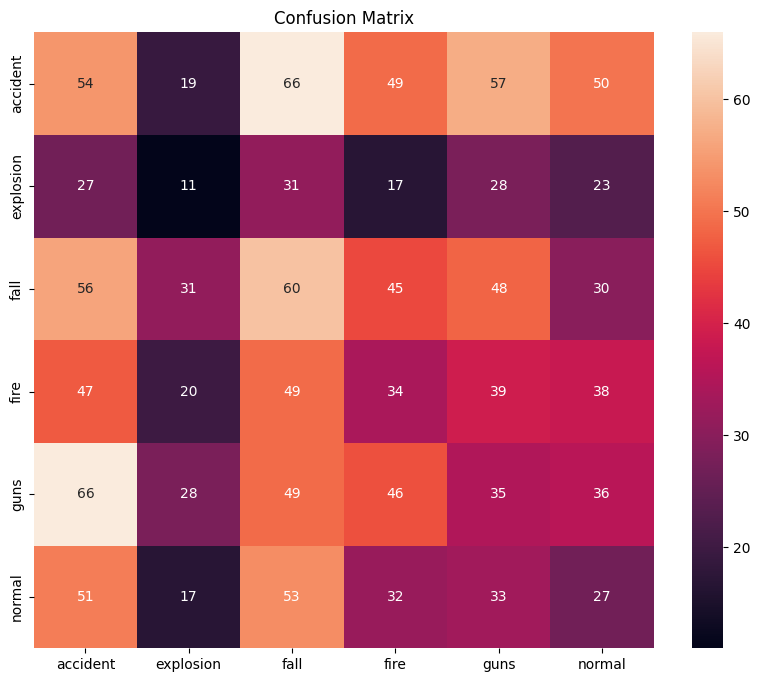

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Import any other necessary libraries if they were not imported previously in this cell


# Generate predictions
val_preds = model.predict(val_generator)
val_labels = np.argmax(val_preds, axis=1)

# Get class names from the generator
class_names = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(val_generator.classes, val_labels,
                            target_names=class_names))

# Confusion matrix visualization

cm = confusion_matrix(val_generator.classes, val_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Convert to TFLite for edge deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('surveillance_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Grad-CAM visualization (for explainability)
from tf_keras_vis.gradcam import Gradcam
gradcam = Gradcam(model)
heatmap = gradcam(model.input,
                 model.output,
                 penultimate_layer=-1)